<a href="https://colab.research.google.com/github/hetaskesen/FeedbackAutomation/blob/main/V1_Whova_Automated_Feedback_Visualizer%2BSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whova Feedback Data Analyzer

This code is fully automated and takes data from the Whova application which can be uploaded either in full, to get an average of all collected data or the excel can be edited to only upload data from specific dates (instructions can be added [ask]).

The **last line** of the code is a automation to download graphics straight to your computer, but can be commented out (put a # in front of files).

Saving schol_202507_responses (4).xlsx to schol_202507_responses (4).xlsx
Saving schol1_202507_responses (1).xlsx to schol1_202507_responses (1).xlsx
Saving schol1_202508_responses.xlsx to schol1_202508_responses (2).xlsx
Saving schol_202508_responses.xlsx to schol_202508_responses (2).xlsx
Average Ratings per Site:


,Site,Aligned to objectives,Expanded Knowledge,Session was engaging
0,DePaul,4.88,4.88,4.67
1,MSU,4.83,4.62,4.65
2,NCC,4.80,4.75,4.76
3,NIU4,4.85,4.72,4.75
4,SXU,4.55,4.44,4.58
5,UIC,4.49,4.24,4.27
6,UIUC,5.00,5.00,5.00
7,Virtual,5.00,5.00,5.00


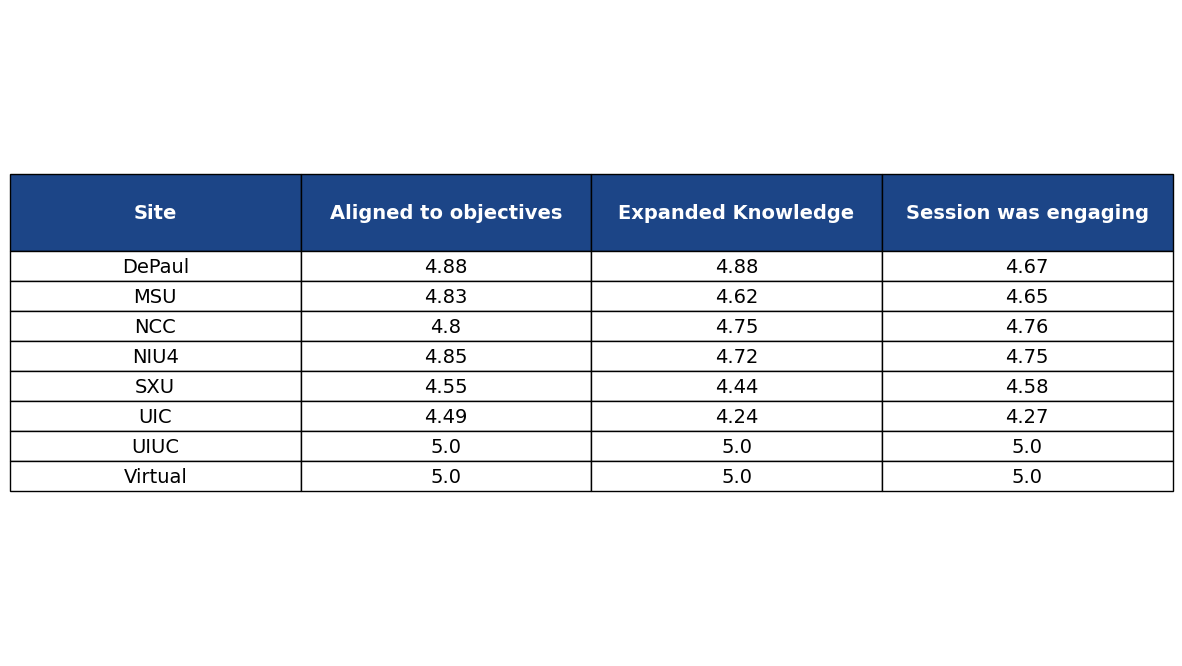

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: NCC**


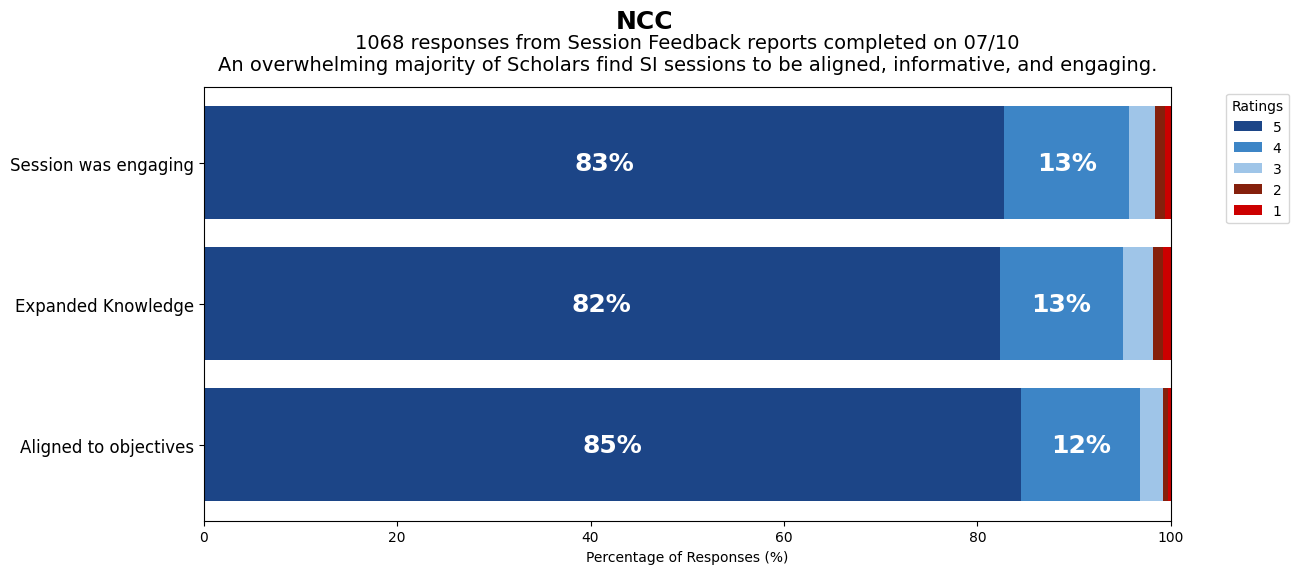

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: UIUC**


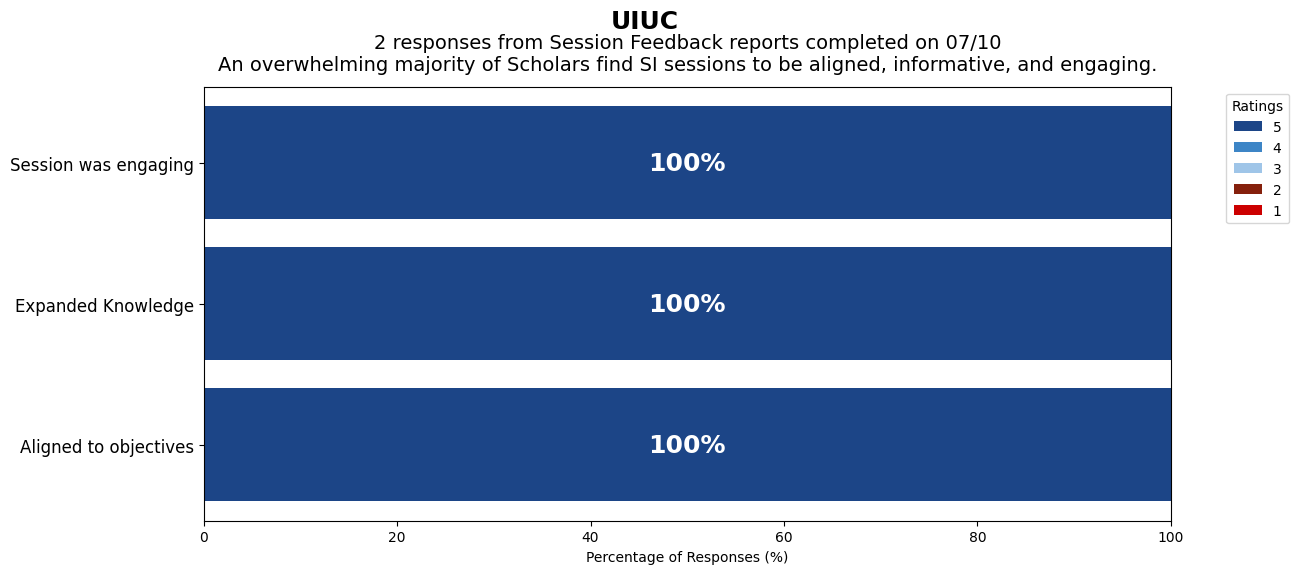

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: DePaul**


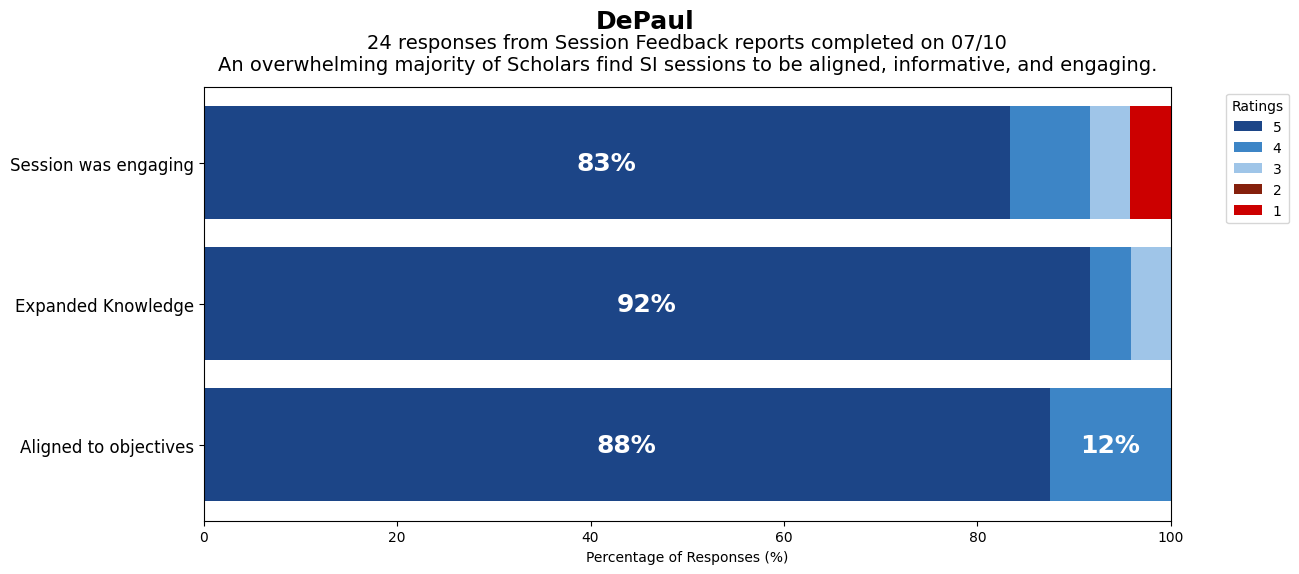

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: UIC**


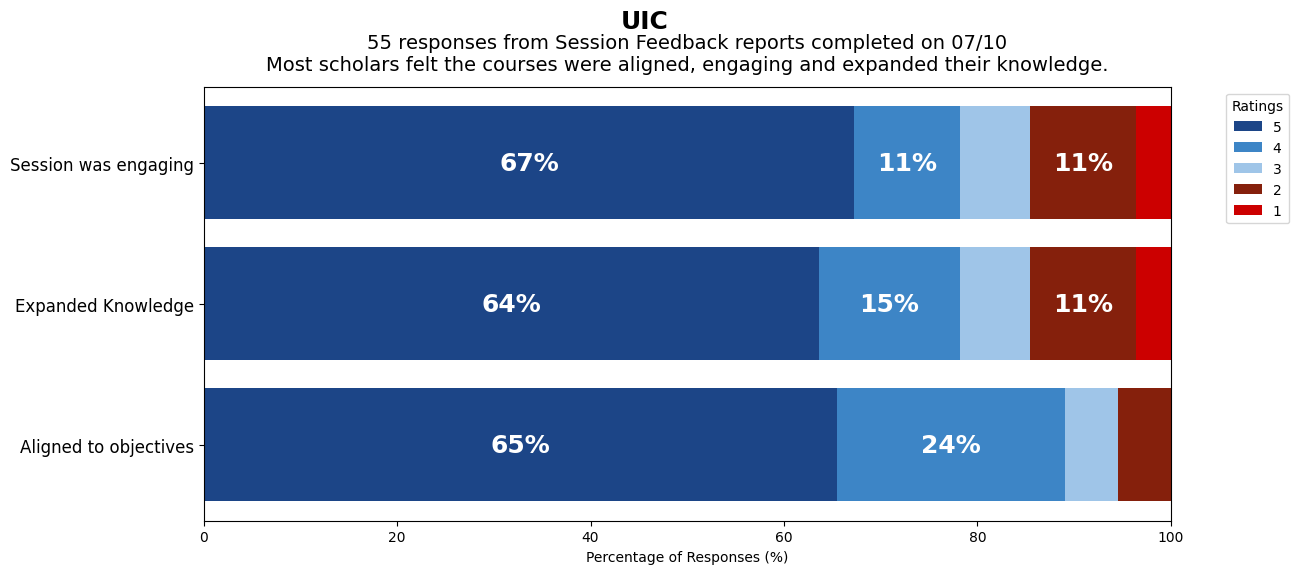

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: SXU**


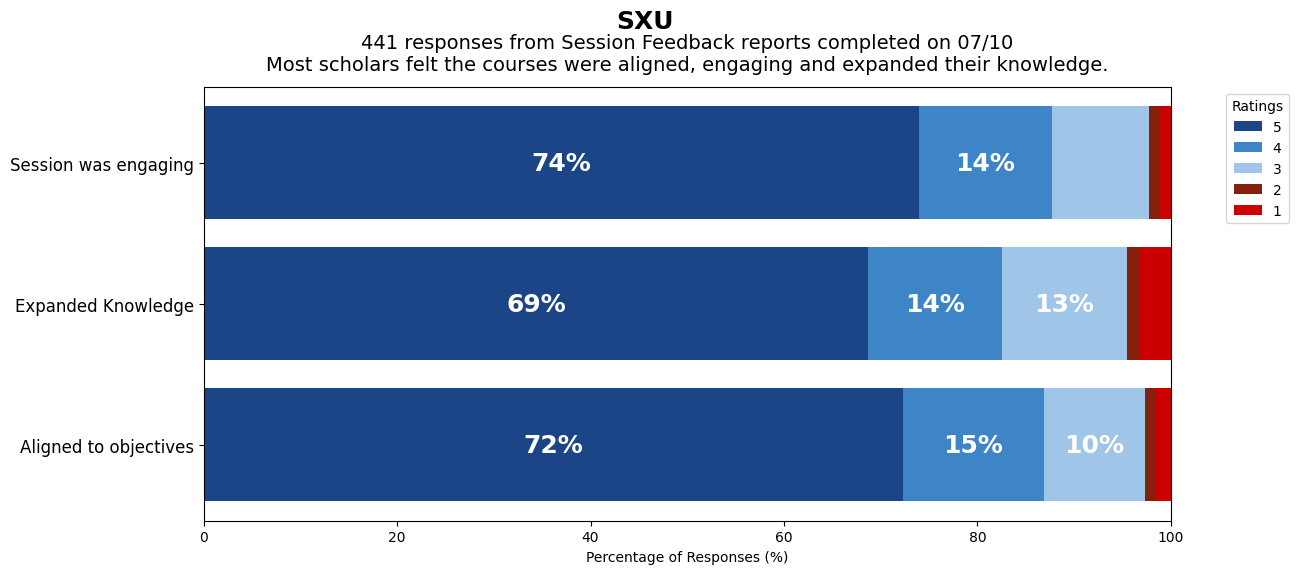

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: Virtual**


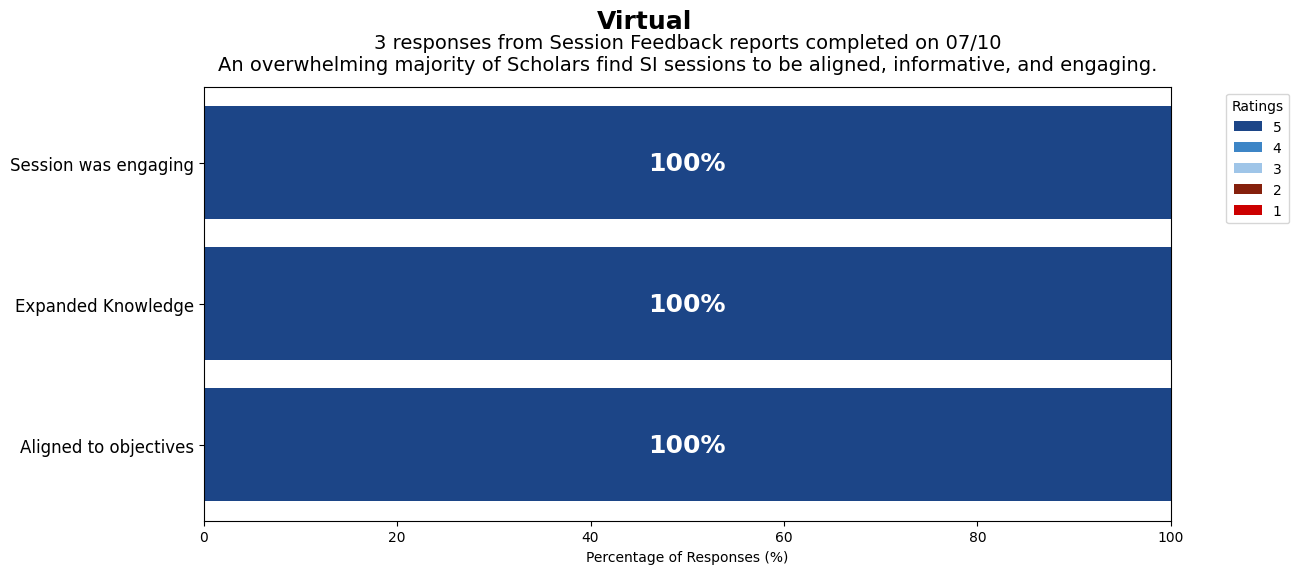

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: NIU4**


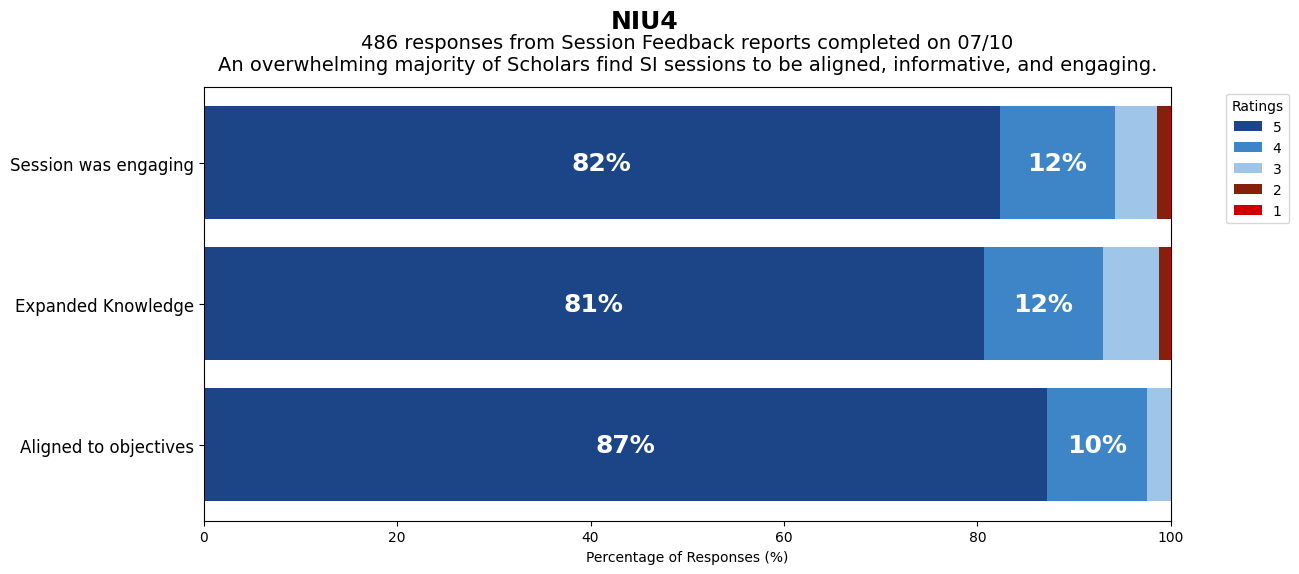

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 **Site: MSU**


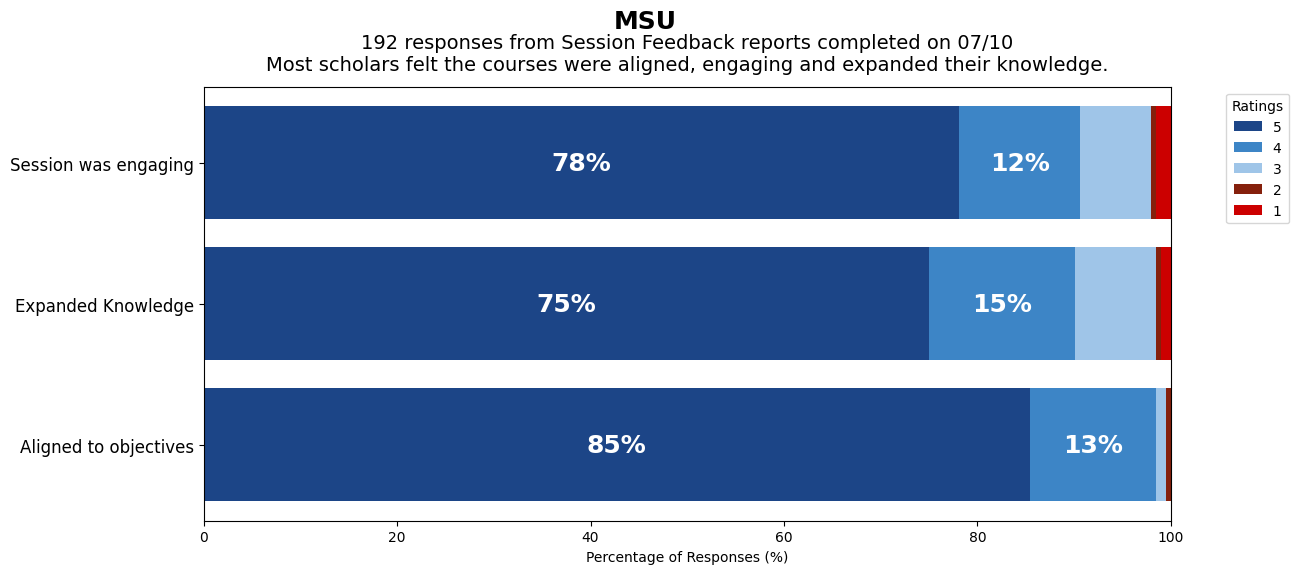

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import re
from google.colab import files
import io
import matplotlib.pyplot as plt

# Mapping of full question text to shorter labels
question_label_map = {
    "This session was aligned to the defined objectives of the course.": "Aligned to objectives",
    "This session expanded my knowledge beyond what I am learning at my university education classes.": "Expanded Knowledge",
    "The session was engaging and modeled instructional best practices.": "Session was engaging"
}

# Upload one or more files
uploaded = files.upload()

# Combine all uploaded Excel files into one DataFrame
df_list = []

for filename in uploaded:
    temp_df = pd.read_excel(io.BytesIO(uploaded[filename]))
    df_list.append(temp_df)

# Concatenate all data into one dataframe
df = pd.concat(df_list, ignore_index=True)


# Clean column names
df.columns = df.columns.str.strip()

# Identify rating columns by keyword
rating_columns = [col for col in df.columns if any(
    kw in col.lower() for kw in ["aligned", "expanded", "engaging"]
)]

# Dynamically extract the first word from 'Session Track(s)' as the site
df['Site'] = df['Session Track(s)'].astype(str).apply(lambda x: x.split()[0] if pd.notna(x) else 'Other')

# Get all unique sites
all_sites = df['Site'].unique()

# Extract the date from the first timestamp
first_date_raw = df['Timestamp'].iloc[0]
first_date = pd.to_datetime(first_date_raw).strftime('%m/%d')

# ---------- Create Average Ratings Table with Shortened Headers ---------- #
# Calculate averages
avg_df = df.groupby("Site")[rating_columns].mean().round(2).reset_index()

# Rename columns to shortened labels
short_label_map = {full: question_label_map[full] for full in rating_columns}
avg_df = avg_df.rename(columns=short_label_map)

print("Average Ratings per Site:")
display(avg_df)

# ---------- Create and Save Average Table as PNG ---------- #
fig, ax = plt.subplots(figsize=(len(avg_df.columns) * 2.5, len(avg_df) * 0.8 + 2))  # Auto-size based on number of sites and columns
ax.axis('off')  # Hide axes

# Build the table
table = ax.table(cellText=avg_df.values, colLabels=avg_df.columns, cellLoc='center', loc='center', colColours=['#1c4587'] * len(avg_df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.5, 1.8)  # Make cells significantly wider and taller

# Bold the header row and make header text white
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#1c4587')  # Dark blue header
        cell.set_height(0.12)  # Add extra height to header

# Save the table as a PNG
table_filename = "Average_Ratings_Per_Site_Table.png"
plt.savefig(table_filename, bbox_inches='tight', transparent=False)
plt.show()

# Offer download link for the table image
files.download(table_filename)

# ---------- Graphs per Site ---------- #
for site in all_sites:
    site_df = df[df["Site"] == site]

    print(f"\n **Site: {site}**")

    if site_df.empty:
        print(f"No responses for {site}")
        continue

    # Prepare data for plotting
    site_summary_rows = []

    for question in rating_columns:
        counts = site_df[question].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0).astype(int)
        total = counts.sum()

        percentages = (counts / total * 100).round(2)

        row = {
            "Short Question": question_label_map[question],
            "1": percentages[1],
            "2": percentages[2],
            "3": percentages[3],
            "4": percentages[4],
            "5": percentages[5]
        }
        site_summary_rows.append(row)

    summary_df = pd.DataFrame(site_summary_rows)

    # Calculate total responses and % of 5's
    total_responses = len(site_df)
    total_fives = summary_df["5"].mean()

    # Determine subtitle based on % of 5's
    if total_fives > 80:
        subtitle = 'An overwhelming majority of Scholars find SI sessions to be aligned, informative, and engaging.'
    elif 55 <= total_fives <= 80:
        subtitle = 'Most scholars felt the courses were aligned, engaging and expanded their knowledge.'
    else:
        subtitle = 'There was a bit of mixed feelings amongst scholars about the courses.'

    # Plot the stacked bar graph
    fig, ax = plt.subplots(figsize=(13, 6))  # Slightly taller to fit subtitles

    categories = ["5", "4", "3", "2", "1"]
    bottom = pd.Series([0] * len(summary_df))

    colors = ['#1c4587', '#3d85c6', '#9fc5e8', '#85200c', '#cc0000']

    bars = []

    for idx, cat in enumerate(categories):
        bars.append(ax.barh(summary_df['Short Question'], summary_df[cat], left=bottom, label=f'{cat}', color=colors[idx]))
        bottom += summary_df[cat]

    # Add labels inside bars for percentages > 10%
    for idx, cat in enumerate(categories):
        for bar_idx, bar in enumerate(bars[idx]):
            width = bar.get_width()
            if width > 10:
                ax.text(bar.get_x() + width / 2, bar.get_y() + bar.get_height() / 2,
                        f'{width:.0f}%', ha='center', va='center', color='white', fontsize=18, fontweight='bold')

    ax.set_xlim(0, 100)
    ax.set_xlabel('Percentage of Responses (%)')

    # Smaller title and subtitle, bold site name
    # Bold site name as a separate suptitle
    plt.suptitle(f'{site}', fontsize=18, fontweight='bold', y=0.95)

    # Regular title below
    ax.set_title(f'{total_responses} responses from Session Feedback reports completed on {first_date}\n{subtitle}', fontsize=14, pad=12)



    ax.tick_params(axis='y', labelsize=12)
    plt.subplots_adjust(left=0.3)

    ax.legend(title='Ratings', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save graph as PNG with transparent background
    filename = f"{site.replace(' ', '_')}_graph.png"
    plt.savefig(filename, transparent=True, bbox_inches='tight')

    # Show graph
    plt.show()

    # Offer download link for the graph
    files.download(filename)
